<a href="https://colab.research.google.com/github/kuds/rl-car-racing/blob/main/%5BCar%20Racing%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimitization (PPO)

In [1]:
!pip install swig

In [2]:
!pip install stable_baselines3 gymnasium[box2d]

In [3]:
import gymnasium
from gymnasium.wrappers import RecordVideo
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.vec_env import VecFrameStack, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecTransposeImage
import os
import torch
import numpy
import platform
import stable_baselines3
import matplotlib
import matplotlib.pyplot
from platform import python_version
from importlib.metadata import version

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"IPython Version: {version('ipython')}")

Python Version: 3.10.12
Torch Version: 2.5.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Scipy Version: 1.13.1
Swig Version: 4.3.0
Stable Baselines3 Version: 2.4.0
IPython Version: 7.34.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
env = gymnasium.make('CarRacing-v3')
print("Observation Space Size: ", env.observation_space.shape)
print("Action Space Size: ", env.action_space.shape)
env.close()

Observation Space Size:  (96, 96, 3)
Action Space Size:  (3,)


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/

In [6]:
env_str = "CarRacing-v3"
log_dir = "./logs/{}".format(env_str)
gray_scale = True

# If gray_scale True, convert obs to gray scale 84 x 84 image
wrapper_class = WarpFrame if gray_scale else None

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Create Training CarRacing environment
env = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create Evaluation CarRacing environment
env_val = make_vec_env(env_str, n_envs=1, wrapper_class=wrapper_class)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=25_000,
                             render=False,
                             n_eval_episodes=20)

# Initialize PPO
# ent_coef - encourages exploration of other actins
model = PPO('CnnPolicy', env, verbose=0, ent_coef=0.005)

# Train the model
model.learn(total_timesteps=750_000,
            progress_bar=True,
            callback=eval_callback)

# Save the model
model.save(os.path.join(log_dir, "ppo_car_racing"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

Eval num_timesteps=25000, episode_reward=-76.34 +/- 2.13

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=50000, episode_reward=-6.85 +/- 33.42

Episode length: 962.90 +/- 161.72

New best mean reward!

Eval num_timesteps=75000, episode_reward=57.75 +/- 84.01

Episode length: 882.20 +/- 280.45

New best mean reward!

Eval num_timesteps=100000, episode_reward=349.67 +/- 123.28

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=125000, episode_reward=187.87 +/- 113.74

Episode length: 990.15 +/- 42.94

Eval num_timesteps=150000, episode_reward=263.07 +/- 122.29

Episode length: 986.50 +/- 58.85

Eval num_timesteps=175000, episode_reward=241.62 +/- 192.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=200000, episode_reward=234.28 +/- 174.34

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=225000, episode_reward=311.44 +/- 228.22

Episode length: 975.40 +/- 89.84

Eval num_timesteps=250000, episode_reward=436.83 +/- 243.13

Episode length: 993.00 +/- 30.51

New best mean reward!

Eval num_timesteps=275000, episode_reward=495.19 +/- 280.76

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=300000, episode_reward=674.57 +/- 251.61

Episode length: 995.05 +/- 14.99

New best mean reward!

Eval num_timesteps=325000, episode_reward=638.02 +/- 281.53

Episode length: 983.45 +/- 52.16

Eval num_timesteps=350000, episode_reward=807.90 +/- 199.40

Episode length: 988.65 +/- 49.47

New best mean reward!

Eval num_timesteps=375000, episode_reward=810.91 +/- 148.03

Episode length: 934.15 +/- 90.04

New best mean reward!

Eval num_timesteps=400000, episode_reward=883.90 +/- 43.98

Episode length: 961.45 +/- 56.67

New best mean reward!

Eval num_timesteps=425000, episode_reward=873.87 +/- 31.53

Episode length: 981.80 +/- 37.85

Eval num_timesteps=450000, episode_reward=876.24 +/- 72.47

Episode length: 942.65 +/- 68.49

Eval num_timesteps=475000, episode_reward=845.40 +/- 136.14

Episode length: 963.45 +/- 52.69

Eval num_timesteps=500000, episode_reward=510.43 +/- 329.19

Episode length: 713.85 +/- 220.66

Eval num_timesteps=525000, episode_reward=682.63 +/- 353.18

Episode length: 822.85 +/- 248.67

Eval num_timesteps=550000, episode_reward=800.99 +/- 175.63

Episode length: 932.15 +/- 94.13

Eval num_timesteps=575000, episode_reward=359.30 +/- 168.00

Episode length: 984.95 +/- 65.60

Eval num_timesteps=600000, episode_reward=680.51 +/- 219.28

Episode length: 990.00 +/- 37.28

Eval num_timesteps=625000, episode_reward=812.42 +/- 85.00

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=650000, episode_reward=791.34 +/- 109.78

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=675000, episode_reward=806.51 +/- 71.06

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=700000, episode_reward=822.35 +/- 191.25

Episode length: 985.30 +/- 45.32

Eval num_timesteps=725000, episode_reward=762.92 +/- 260.81

Episode length: 986.65 +/- 58.19

Eval num_timesteps=750000, episode_reward=870.58 +/- 47.73

Episode length: 969.75 +/- 72.77

Mean reward: 830.99 +/- 194.60


In [8]:
# Create Evaluation CarRacing environment
env = make_vec_env(env_str, n_envs=1, seed=0, wrapper_class=WarpFrame)
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing CarRacing
env = VecVideoRecorder(env, "./videos/",
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_car_racing_ppo")

obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model - Mean reward: 887.84 +/- 46.79


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_car_racing_ppo-step-0-to-step-10000.mp4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


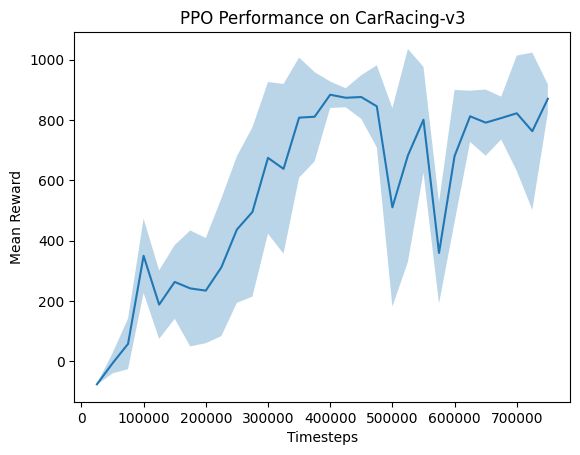

In [9]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"PPO Performance on {env_str}")
matplotlib.pyplot.show()